# Unstructured Mesh: Introduction

In this example we'll look at how to setup and use unstructured mesh tallies in OpenMC. Unstructured meshes are able to provide results over spatial regions of a problem while conforming to a specific geometric features -- something that is often difficult to do using the regular and rectilinear meshes in OpenMC.

Here, we'll apply an unstructured mesh tally to the PWR assembly model from the OpenMC examples.

**_NOTE: This notebook will not run successfully if OpenMC has not been built with DAGMC or libMesh support enabled._**

In [1]:
from IPython.display import Image
import openmc
import openmc.lib

# ensure one of the two mesh libraries is enabled
assert(openmc.lib._dagmc_enabled() or openmc.lib._libmesh_enabled())

We'll need to download the unstructured mesh file used in this notebook. We'll be retrieving those using the function and URLs below.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

import urllib.request

pin_mesh_moab_url = 'https://tinyurl.com/u9ce9d7' # MOAB file - 22 MB
pin_mesh_libmesh_url = 'https://tinyurl.com/yysgs3tr' # Exodus file - 9.7 MB

def download(url, filename='dagmc.h5m'):
    """
    Helper function for retrieving dagmc models
    """
    u = urllib.request.urlopen(url)
    
    if u.status != 200:
        raise RuntimeError("Failed to download file.")
    
    # save file as dagmc.h5m
    with open(filename, 'wb') as f:
        f.write(u.read())

First we'll import that model from the set of OpenMC examples.

In [3]:
model = openmc.examples.pwr_assembly()

We'll make a couple of adjustments to this 2D model as it won't play very well with the 3D mesh we'll be looking at. First, we'll bound the pincell between +/- 10 cm in the Z dimension.

In [4]:
min_z = openmc.ZPlane(z0=-10.0)
max_z = openmc.ZPlane(z0=10.0)

z_region = +min_z & -max_z

cells = model.geometry.get_all_cells()
for cell in cells.values():
    cell.region &= z_region

The other adjustment we'll make is to remove the reflective boundary conditions on the X and Y boundaries. (This is purely to generate a more interesting flux profile.)

In [5]:
surfaces = model.geometry.get_all_surfaces()
# modify the boundary condition of the
# planar surfaces bounding the assembly
for surface in surfaces.values():
    if isinstance(surface, openmc.Plane):
        surface.boundary_type = 'vacuum'

Let's take a quick look at the model to ensure our changs have been added properly.

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

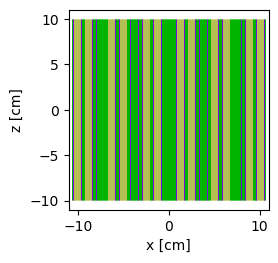

In [6]:
root_univ = model.geometry.root_universe

# axial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(200, 300),
               basis='xz',
               color_by='material',
               seed=1)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

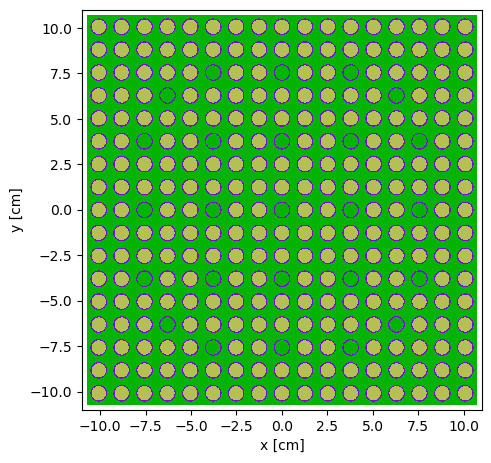

In [7]:
# radial image
root_univ.plot(width=(22.0, 22.0),
               pixels=(400, 400),
               basis='xy',
               color_by='material',
               seed=1)

Looks good! Let's run some particles through the problem.

In [8]:
model.run()

[v5:186430] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

PosixPath('/home/joe/PYTHON_FILES/OPENMC/Copies/statepoint.10.h5')

Now it's time to apply our mesh tally to the problem. We'll be using the tetrahedral mesh "pins1-4.h5m" shown below:

In [9]:
#Image("./images/pin_mesh.png", width=600)

This mesh was generated using Trelis with radii that match the fuel/coolant channels of the PWR model. These four channels correspond to the highlighted channels of the assembly below.

Two of the channels are coolant and the other two are fuel.

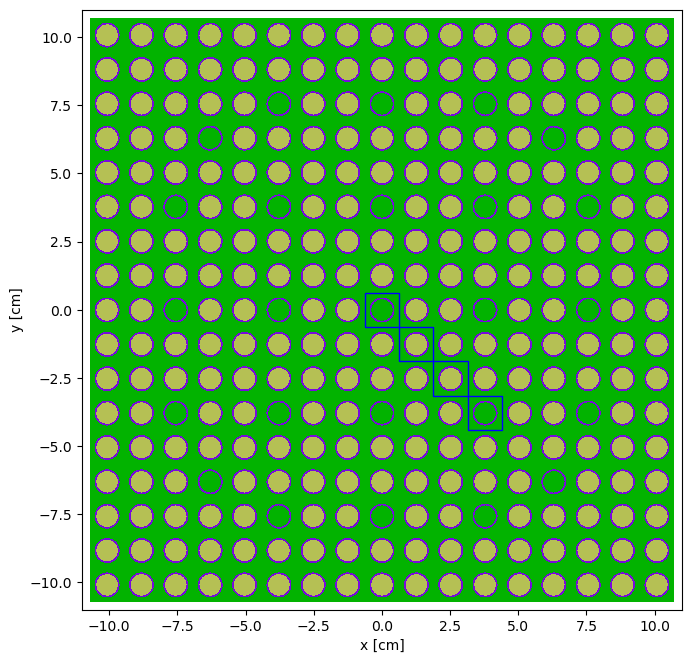

In [10]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

pitch = 1.26 # cm

img = root_univ.plot(width=(22.0, 22.0),
                           pixels=(600, 600),
                           basis='xy',
                           color_by='material',
                           seed=1)

# highlight channels
for i in range(0, 4):
    corner = (i * pitch - pitch / 2.0, -i * pitch - pitch / 2.0)
    rect = Rectangle(corner,
                     pitch,
                     pitch,
                     edgecolor='blue',
                     fill=False)
    img.axes.add_artist(rect)

### Applying an unstructured mesh tally

To use this mesh, we'll create an unstructured mesh instance and apply it to a mesh filter. We do this by specifying a mesh file and mesh library on an `UnstructuredMesh` object. The specified mesh library will be used to load the mesh file during simulation initialization. OpenMC must be built with support for the specified mesh library enabled.

In [11]:
mesh_library = 'moab' # change to 'libmesh' to use libMesh instead

if mesh_library == 'moab':
    assert(openmc.lib._dagmc_enabled())
    mesh_file = 'pins1-4.h5m'
    mesh_url = pin_mesh_moab_url
elif mesh_library == 'libmesh':
    assert(openmc.lib._libmesh_enabled())
    mesh_file = 'pins1-4.e'
    mesh_url = pin_mesh_libmesh_url
    
# download the file and create the UnstructuredMesh object
download(mesh_url, mesh_file)
umesh = openmc.UnstructuredMesh(mesh_file, library=mesh_library)

Regardless of the library used to represent the mesh, we can apply this mesh object in a `MeshFilter`.

In [12]:
mesh_filter = openmc.MeshFilter(umesh)

We can now apply this filter like any other. For this demonstration we'll score both the flux and heating in these pins.

In [13]:
tally = openmc.Tally()
tally.filters = [mesh_filter]
tally.scores = ['heating', 'flux']
# Only collision estimators are supported for 
if umesh.library == 'libmesh':
    tally.estimator = 'collision'
model.tallies = [tally]

Now we'll run this model with the unstructured mesh tally applied. Notice that the simulation takes some time to start due to some additional data structures used by the unstructured mesh tally. Additionally, the particle rate drops dramatically during the active cycles of this simulation.

Unstructured meshes are useful, but they can be computationally expensive!

In [14]:
model.settings.particles = 10_000
model.settings.inactive = 20
model.settings.batches = 100
sp_file = model.run(output=True)

[v5:186472] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

### Statepoint Data

In previous implementations of unstructured mesh filters, the `openmc` executable would produce VTK files. This capability was limited to tallies with one or two filters to avoid exceedingly large VTK files.

Since version 0.13.1, VTK files can be generated for any mesh type using the Python API. The information necessary to write VTK files for unstructured meshes is only available on mesh objects created by loading a statpoint file. Arbitrarily generated element-wise data can be applied to the VTK file, meaning that any data collected from `openmc.Tally` objects (or any other source) can be applied to the resulting VTK mesh.

Here, we'll generated a single VTK file that contains the mean and standard deviation of the flux and heating scores.

In [15]:
with openmc.StatePoint(sp_file) as sp:
    sp_tally = sp.get_tally(id=tally.id)
    sp_umesh = sp_tally.find_filter(openmc.MeshFilter).mesh
    
# data coming from the tally object will have three dimensions.
# make sure to shape the results to match the mesh elements
flux_mean = sp_tally.get_values(scores=['flux'], value='mean').reshape(sp_umesh.dimension)
flux_std_dev = sp_tally.get_values(scores=['flux'], value='std_dev').reshape(sp_umesh.dimension)
heating_mean = sp_tally.get_values(scores=['heating'], value='mean').reshape(sp_umesh.dimension)
heating_std_dev = sp_tally.get_values(scores=['heating'], value='std_dev').reshape(sp_umesh.dimension)

vtk_data_dict = {'flux_mean': flux_mean,
                 'flux_std_dev': flux_std_dev,
                 'heating_mean': heating_mean,
                 'heating_std_dev': heating_std_dev}
sp_umesh.write_data_to_vtk('pin_data.vtk', datasets=vtk_data_dict)

Data collected from the tally object with `openmc.Tally.get_values` will have three dimensions (score, filter bins, nuclides). When using the `write_data_to_vtk` method, the data should be shaped to match the mesh dimensions.

Once written, these files can be viewed using free tools like [Paraview](https://www.paraview.org/) and [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit/) to examine the results.

In [20]:
!ls *.vtk

pin_data.vtk


## Flux

In [17]:
#Image("./images/umesh_flux.png", width=600)

## Heating
Here is an image of the heating score as viewed in VisIt. Note that no heating is scored in the water-filled channels as expected.

In [18]:
#Image("./images/umesh_heating.png", width=600)

In [19]:
#Image("./images/umesh_w_assembly.png", width=600)